(Fraction(1, 1),
 {'t3=2': {'p(t4=3 | t3=2)': Fraction(1, 1), 'p(t3=2)': Fraction(1, 4)},
  't4=3': {'p(t4=3)': Fraction(1, 4)}})

## COMP3670/6670 Programming Assignment 3 - Linear Regression ##
---

**Enter Your Student ID:** u7540836

**Your Name:** Nanthawat Anancharoenpakorn
    
**Deadline:** 10 Oct 2023

**Submit:** Write your answers in this file, and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Note: you don't need to submit the .png or .npy files. 

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.
Please implement things by yourself. If you use any external resources, list them here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The following section provides some helper functions.

In [2]:
## GENERAL FUNCTIONS - DO NOT MODIFY ##
def lr_mle(X, y):
    # maximum likelihood (least squares) for linear regression 
    XtX = np.dot(X.T, X)
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_map(X, y, alpha=0.1):
    # maximum a-posteriori (regularised least squares) for linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_bayes(X, y, alpha=0.1, noise_var=0.01):
    # exact posterior for Bayesian linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    mean = np.linalg.solve(XtX, Xty)
    # note: calling inv directly is not ideal
    cov = np.linalg.inv(XtX) * noise_var
    return mean, cov

def predict_point(X, theta):
    # predict given parameter estimate
    return np.dot(X, theta)

def predict_bayes(X, theta_mean, theta_cov):
    # predict gien parameter posterior
    mean = np.dot(X, theta_mean)
    cov = np.dot(X, np.dot(theta_cov, X.T))
    return mean, cov

def add_bias_col(x):
    # add an all-one column
    n = x.shape[0]
    return np.hstack([x, np.ones([n, 1])])

## END GENERAL FUNCTIONS ##

### **Task 0: Warming Up** ###

The following code block visualises the difference between different methods of performing linear regression. 

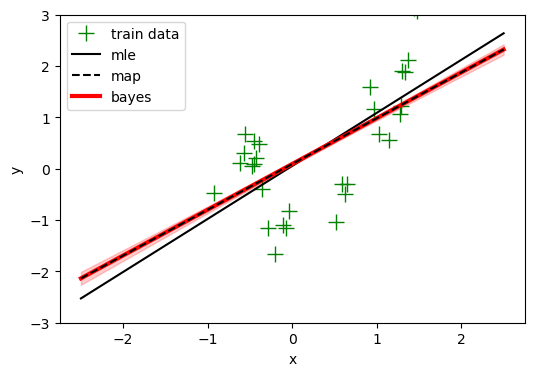

In [3]:
# load data
data = np.loadtxt("./data/ass3_data1_train.txt")
x_train, y_train = data[:, 0][:, None], data[:, 1][:, None]
data = np.loadtxt("./data/ass3_data1_valid.txt")
x_valid, y_valid = data[:, 0][:, None], data[:, 1][:, None]

# some data for visualisation
N_plot = 100
x_plot = np.linspace(-2.5, 2.5, N_plot).reshape([N_plot, 1])

# add one col to the inputs
x_train_with_bias = add_bias_col(x_train)
x_plot_with_bias = add_bias_col(x_plot)

# MLE = least squares
theta_mle = lr_mle(x_train_with_bias, y_train)
f_mle = predict_point(x_plot_with_bias, theta_mle)

# MAP = regularised least squares
alpha = 0.1
theta_map = lr_map(x_train_with_bias, y_train, alpha)
f_map = predict_point(x_plot_with_bias, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_with_bias, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_with_bias, theta_mean, theta_cov)

# plot utility
def plot(x, y, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov):
    # plot utility
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, '+g', label='train data', ms=12)
    if f_mle is not None:
        plt.plot(x_plot, f_mle, '-k', label='mle')
    if f_map is not None:
        plt.plot(x_plot, f_map, '--k', label="map", zorder=10)
    if f_bayes_mean is not None:
        plt.plot(x_plot, f_bayes_mean, '-r', label="bayes", lw=3)
        f_std = np.sqrt(np.diag(f_bayes_cov))
        upper = f_bayes_mean[:, 0] + 2*f_std
        lower = f_bayes_mean[:, 0] - 2*f_std
        plt.fill_between(x_plot[:, 0], upper, lower, color='r', alpha=0.2)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3, 3])

# plot the training data and predictions
plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 1: What makes a good regression?** ###

As can be seen from the visualisation above, the regressed line seems to be far from the datapoints. Are there any ways we can improve the regression?

**Task 1.1**

Explain why the above linear regression fails. 

Since the data point between x and y does not show a clear linear relationship, the linear regression model can't capture this complexity well. In general, outiler is also one of the reason that linear 

**Task 1.2**

What kind of features would lead to a better result? Why? 

To tackle this problem, we can introduce ploynomial features because it capture nonlinear relationships between variables.

**Task1.3**

Implement `featurise` function that takes raw datapoints as the input and output a reasonable design matrix $\Phi$ according to the method you mentioned in **Task 1.2**.

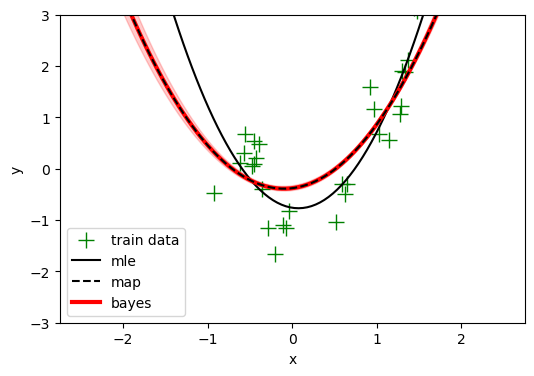

In [4]:
# Select hyperparam to 2 
def featurise(x, degree=2):
    
    # Initialize 
    features = np.ones((x.shape[0], 1))
    
    # Generate polynomial feature
    for d in range(1, degree + 1):
        features = np.hstack([features, x**d])
    
    return features

x_train_feat = featurise(x_train)
x_valid_feat = featurise(x_valid)
x_plot_feat = featurise(x_plot) 

# repeat but now with features
# MLE
theta_mle = lr_mle(x_train_feat, y_train)
f_mle = predict_point(x_plot_feat, theta_mle)

# MAP
alpha = 0.1
theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)

plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 2: Estimating noise variance through the marginal likelihood** ###

One commonly asked question in Bayesian linear regression is how can we define the noise level of the target. In previous questions, we set the noise variance in `lr_bayes` to be 0.01 - a fixed constant. But intuitively, after we have observed some datapoints, the noise level can actually be inferred or estimated. This tasks is designed for you to investigate the marginal likelihood (a.k.a. model evidence) and how we can use this to pick the noise variance. 

**Task 2.1**

Implement the negative log marginal likelihood, given the noise level of the likelihood, training inputs and outputs, and the prior variance. We can pick `prior_var` using the same procedure, but assume `prior_var = 0.5` for this exercise. The form of the marginal likelihood is provided in Week 7's lecture slides.

In [5]:
# 2a
def negative_log_marginal_likelihood(noise_var, x, y, prior_var=0.5):
    
    n, d = x.shape
    # Calculate noise variance term
    noise_term = (n / 2) * np.log(2 * np.pi * noise_var)
    
    # Calculate residual term
    theta_mle = np.linalg.inv(x.T @ x) @ x.T @ y  
    rss_term = (1 / (2 * noise_var)) * ((y - x @ theta_mle).T @ (y - x @ theta_mle))
    neg_log_marg_lik = noise_term + rss_term
    
    return neg_log_marg_lik[0, 0] 

**Task 2.2**

Select the most appropriate noise level that minimises the negative log marginal likelihood. In practice, we can do this mimimisation by gradient descent, but for this exercise, we assume we have access to a predefined set of potential noise levels and just need to pick one.




In [6]:
# 2.2
# a predefined list
potential_noise_vars = np.logspace(-4, 1.5, 50)

# Initialize min
min_neg_log_marg_lik = float('inf')

# Initialize output 
best_noise_var = None

for noise_var in potential_noise_vars:
    # Calculate negative log marginal likelihood given current noise
    curr_neg_log_marg_lik = negative_log_marginal_likelihood(noise_var, x_train_feat, y_train)
    
    # Update min and best noise
    if curr_neg_log_marg_lik < min_neg_log_marg_lik:
        min_neg_log_marg_lik = curr_neg_log_marg_lik
        best_noise_var = noise_var
        
noise_var_estimated = best_noise_var

**Task 2.3**

We visualise the predictions using the estimated noise variance, and compare to those when the noise is very large or very small. Based on these graphs and the negative log marginal likelihood corresponding to these noise levels, explain why finding a proper noise level of the likelihood is important. 

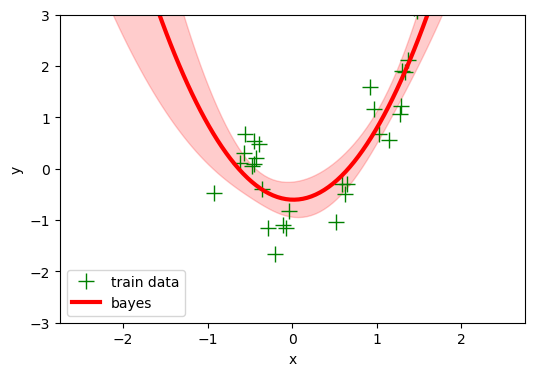

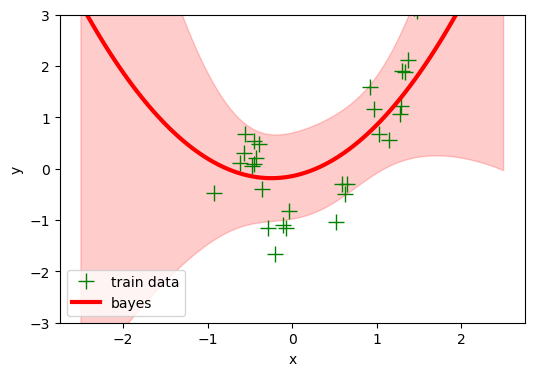

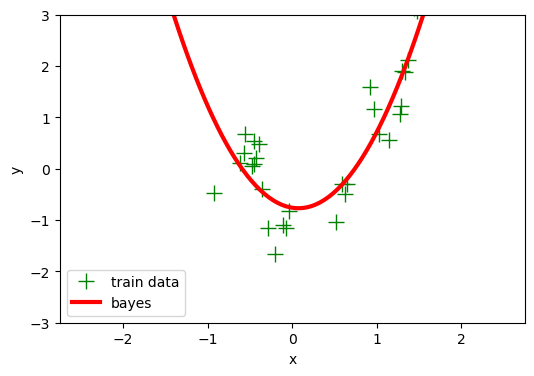

In [7]:
# fit with the estimated noise variance
N = x_train_feat.shape[0]
prior_var = 0.5
alpha = noise_var_estimated / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var_estimated)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very large noise
noise_var = 5
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very small noise
noise_var = 0.00001
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

The estimate noise should be balance, not too much and not too little. For example, the figure two in the midde shows that the confident band is vary wide around the regression line. This indicate that there is a high uncertainty in prediction. On the third plot which is very low noise, it shows a very narrow band which we can't even see. It tends to overfit which might lead to incorrect prediction easier. The right value of noise will capture true underlying variation which is not overfit or underfit. 

** Task 2.4 - Optional **

The naive implementation of the negative log marginal likelihood above would require the inverse of an N by N matrix, which is of time complexity $\Theta(N^3)$. This is computationally intractable for a large dataset (large N). Can we speed this up?

In [8]:
data = np.loadtxt("./data/ass3_data1_train_large.txt")
x_large, y_large = data[:, 0][:, None], data[:, 1][:, None]
x_large_feat = featurise(x_large)

def negative_log_marginal_likelihood_v2(noise_var, x, y, prior_var=0.5):
    # TODO: implement this
    return 0

### **Task 3: Regularisation** ###

In machine learning, regularisation is an important technique to reduce overfitting. Regularisation also provides better generalisation in general. This task aims to show how regularisation affects the parameter estimates. 

**Task 3.1**

Implement `L1`, `L2`. Both functions take the weight $\theta$ as input, output the regularisation value and the gradient of the regularisation term (**NOT THE GRADIENT OF THE ENTIRE OBJECTIVE FUNCTION**).

In [9]:
def L1(theta):
    reg = np.sum(np.abs(theta))
    grad = np.sign(theta)
    return reg, grad

def L2(theta):
    reg = np.sum(theta ** 2)
    grad = 2 * theta
    return reg, grad

def data_fit(theta, x, y):
    diff = y - np.dot(x, theta) # N x 1
    f = np.mean(diff**2) # 1 x 1
    df = - 2 * np.dot(diff.T, x).T / x.shape[0]
    return f, df 

def objective(theta, x, y, alpha, l2=True):
    reg_func = L2 if l2 else L1
    reg, dreg = reg_func(theta)
    fit, dfit = data_fit(theta, x, y)
    obj = fit + alpha * reg
    dobj = dfit + alpha * dreg
    return obj, dobj

**Task 3.2**

We now run gradient descent and plot the predictions. Comment on the results.

0 9.68033735805853
100 0.5477641061330425
200 0.5476880837274298
300 0.5476880407727662
400 0.5476880407484959
500 0.547688040748482
600 0.5476880407484821
700 0.5476880407484821
800 0.5476880407484821
900 0.5476880407484821
1000 0.5476880407484821
1100 0.5476880407484821
1200 0.5476880407484821
1300 0.5476880407484821
1400 0.5476880407484821
1500 0.5476880407484821
1600 0.5476880407484821
1700 0.5476880407484821
1800 0.5476880407484821
1900 0.5476880407484821
0 0.5834608345749417
100 0.5573230306917372
200 0.5570831968275949
300 0.5565875243787559
400 0.5563557834183728
500 0.557137133937488
600 0.5570061843954037
700 0.5564745544773535
800 0.5567218879654239
900 0.5573385786955712
1000 0.5569311337060469
1100 0.5563889459056663
1200 0.5568076944158364
1300 0.5573044277424987
1400 0.5569056738329459
1500 0.5563685546405848
1600 0.5569630932443451
1700 0.5571279332881606
1800 0.5566160865200267
1900 0.5563177239588664
0 0.3746266053544002
100 0.34508122766269694
200 0.3442888756177954


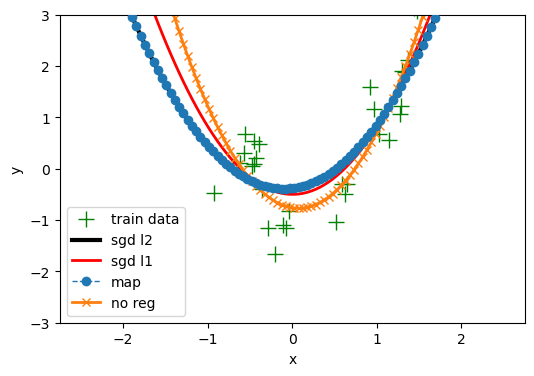

In [10]:
D = x_train_feat.shape[1]
theta_l2_sgd_init = np.random.randn(D, 1)
theta_l2_sgd = theta_l2_sgd_init

no_iters = 2000
learning_rate = 0.1
alpha = 0.1
l2 = True
for i in range(no_iters):
    obj, dobj = objective(theta_l2_sgd, x_train_feat, y_train, alpha, l2)
    theta_l2_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_l2_sgd = predict_point(x_plot_feat, theta_l2_sgd)

theta_l1_sgd = theta_l2_sgd_init
l2 = False
for i in range(no_iters):
    obj, dobj = objective(theta_l1_sgd, x_train_feat, y_train, alpha, l2)
    theta_l1_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)
f_l1_sgd = predict_point(x_plot_feat, theta_l1_sgd)

# Without any regularisation
theta_noreg_sgd = theta_l2_sgd_init
for i in range(no_iters):
    obj, dobj = objective(theta_noreg_sgd, x_train_feat, y_train, 0, l2)
    theta_noreg_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_noreg_sgd = predict_point(x_plot_feat, theta_noreg_sgd)

theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# plot utility
plt.figure(figsize=(6, 4))
plt.plot(x_train, y_train, '+g', label='train data', ms=12)
plt.plot(x_plot, f_l2_sgd, '-k', lw=3, label='sgd l2')
plt.plot(x_plot, f_l1_sgd, '-r', lw=2, label='sgd l1')
plt.plot(x_plot, f_map, '--o', label="map", zorder=10, lw=1)
plt.plot(x_plot, f_noreg_sgd, '-x', label="no reg", lw=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-3, 3])

plt.show()

Generally speaking, no regularization is more fit to the data or noise as we can see that it is most narrow than others such as MAP, L1 or L2 that are more spread out.Another point is that we can't see the black line or L2 due to it is under the blue line or map which confirm that MAP with Gaussian prior is similar to L2 regularization. 